In [1]:
# Set up environment first.
# we will need current numpy for pygrib
import numpy as np, os
if not [int(i) for i in np.__version__.split('.')] >= [1,20,1]: # check numpy version
  print('Upgrading numpy and stopping RUNTIME! When the notebook completes, please run again.')
  ! pip install --upgrade numpy    # suggested by Efosa, see also https://github.com/jswhit/pygrib/issues/192
  os.kill(os.getpid(), 9)          # kill the runtime, need to run again from the beginning! pip install pygrib
! pip install pygrib   
! wget --no-clobber https://raw.githubusercontent.com/openwfm/wrfxpy/master/src/ingest/grib_file.py
from grib_file import GribFile     # Martin's utility layer on top of  pygrib,from wrfxpy

File ‘grib_file.py’ already there; not retrieving.



## Kalman filter

The Kalman filter provides an estimate $u$ of the time evolution of some unknown process, called "nature" or "truth". We do not know with certainty what the nature is, but we can observe it at regular intervals (steps) with some error. In each step, model $F$ advances the model state $u$ in time, $ u \leftarrow F(u)$, and attempts to reconcile the state with an observation $d$ of the true state, so $u \approx d$. The filter modifies the model state $u$ to balance the uncertainty in the model and the data (this is called *analysis*) and the cycle continues. For that purpose, the filter evolves also an estimate of the uncertainly of the model.

More generally, instead of $u \approx d$, only a part of the state is observed, and $Hu \approx d$ where $H$ is a matrix, or observation function. Basically, $Hu$ is what the data would be if the model was completely accurate. 

In [2]:
import numpy as np
def ext_kf(u,P,F,Q=0,d=None,H=None,R=None):
  """
  One step of the extended Kalman filter. 
  If there is no data, only advance in time.
  :param u:   the state vector, shape n
  :param P:   the state covariance, shape (n,n)
  :param Q:   the process model noise covariance, shape (n,n)
  :param F:   the model function, maps vector u to vector F(u) and Jacobian J(u)
  :param d:   data vector, shape (m)
  :param H:   observation matrix, shape (m,n)
  :param R:   data error covariance, shape (n,n)
  :return ua: the analysis state vector, shape (n)
  :return Pa: the analysis covariance matrix, shape (n,n)
  """
  def d2(a):
    return np.atleast_2d(a) # convert to at least 2d array

  def d1(a):
    return np.atleast_1d(a) # convert to at least 1d array

  # forecast
  uf, J  = F(u)          # advance the model state in time and get the Jacobian
  uf = d1(uf)            # if scalar, make state a 1D array
  P = d2(P)              # if scalar, make Jacobian as 2D array
  Pf  = d2(J.T @ P) @ J + Q  # advance the state covariance Pf = J' * P * J + Q
  # analysis
  if d is None or not d.size :  # no data, no analysis
    return uf, Pf
  # K = P H' * inverse(H * P * H' + R) = (inverse(H * P * H' + R)*(H P))'
  H = d2(H)
  HP  = d2(H @ P)            # precompute a part used twice  
  K   = d2(np.linalg.solve( d2(HP @ H.T) + R, HP)).T  # Kalman gain
  # print('H',H)
  # print('K',K)
  res = d1(H @ d1(uf) - d)          # res = H*uf - d
  ua = uf - K @ res # analysis mean uf - K*res
  Pa = Pf - K @ d2(H @ P)        # analysis covariance
  return ua, d2(Pa)


##  A basic exponential decay model of fuel moisture




The evolution of fuel moisture content $m(t)$ is modeled by the differential equation on interval $\left[
t_{0},t_{1}\right]  $,
$$
\frac{dm}{dt}=\frac{E-m(t)}{T},\quad m(t_{0})=m_{0}.
$$
where the initial fuel moisture content $m_{0}=m\left(  t_{0}\right)  $ is the
input, and $m_{1}=m(t_{1})$ is the output. Tnus, $m_1=F(m_0)$. The parameters of the model are the
fuel moisture equilibrium $E$, assumed to be constant over the interval $\left[
t_{0},t_{1}\right]  $, NS the characteristic decay time $T$. 

We can build the general model later by calling this simple model with different
equilibria and time constants (drying, wetting, rain).

Since $E$ is constant in time, the solution can be found
analytically,
$$
m\left(  t\right)  =E+\left(  m_{0}-E\right)  e^{-t/T}%
$$
For convenience, we use $T_{1}=1/T$ instead of $T$, and the model becomes
$$
m_{1}=E+\left(  m_{0}-E\right)  e^{-\left(  t_{1}-t_{0}\right)  T_{1}}%
$$
In the extended Kalman filter, we will need the partial derivatives of $m_{1}$
with respect to the input and the parameters. Compute
$$
\frac{dm_{1}}{d_{m0}}=e^{-\left(  t_{1}-t_{0}\right)  T_{1}}
$$
$$
\frac{dm_{1}}{dE}=1-e^{-\left(  t_{1}-t_{0}\right)  T_{1}}
$$
$$
\frac{dm_{1}}{dT_{1}}=-\left(  m_{0}-E\right)  \left(  t_{1}-t_{0}\right)
e^{-\left(  t_{1}-t_{0}\right)  T_{1}}
$$
At the moment, we need only ${dm_{1}}/{dm_{0}}$ but we put in the code all partials for possible use in future.


In [3]:
import numpy as np
def model_decay(m0,E,partials=0,T1=0.1,tlen=1):
  exp_t = np.exp(-tlen*T1)                  # compute this subexpression only once
  m1 = E + (m0 - E)*exp_t                   # the solution at end
  if partials==0:
    return m1
  dm1_dm0 = exp_t
  if partials==1:
    return m1, np.array([dm1_dm0])          # return value and Jacobian
  dm1_dE = 1 - exp_t                        # partial derivative dm1 / dE
  dm1_dT1 = -(m0 - E)*tlen*exp_t            # partial derivative dm1 / dT1
  return m1, dm1_dm0, dm1_dE, dm1_dT1       # return value and all partial derivatives wrt m1 and parameters
  

## Kalman filter demonstration

We demonstrate the Kalman filter for this model on a simple artificial example. The model is solving the differential equation for one hour. The equilibrium $E$ is constant during the hour, but it changes over the day so that it is higher at night and lower during the day, with a 24-hour period.  First, we create the "truth" by choosing the equilibrium $E$ and solving the differential aquation every hour, with a small additive noise. The synthetic data is obtained as values of the "truth", with random noise to simulate observation error.

### Create synthetic data

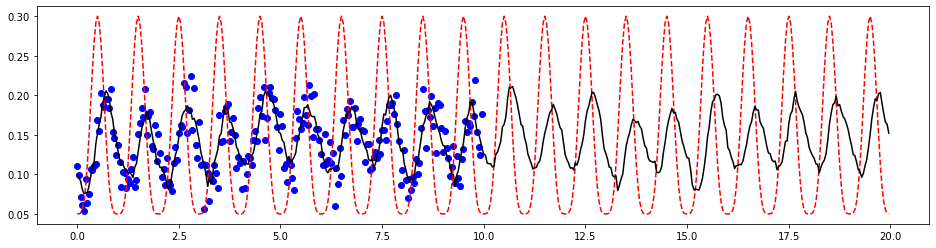

In [4]:
import numpy as np, random
days = 10       
hours = days*24
day = np.array(range(2*hours))/24.

# artificial equilibrium data
E = np.power(np.sin(np.pi*day),4) # diurnal curve
E = 0.05+0.25*E
E # scale 
# FMC free run
m_f = np.zeros(2*hours)
m_f[0] = 0.1         # initial FMC
for t in range(2*hours-1):
  m_f[t+1] = max(0.,model_decay(m_f[t],E[t])  + random.gauss(0,0.005) )
data = m_f + np.random.normal(loc=0,scale=0.02,size=2*hours)    

%matplotlib inline
import matplotlib.pyplot as plt 
plt.figure(figsize=(16,4))
plt.plot(day[0:2*hours],E[0:2*hours],linestyle='--',c='r',label='Equilibrium')
plt.plot(day[0:2*hours],m_f[0:2*hours],linestyle='-',c='k',label='10-h fuel truth')
plt.scatter(day[0:hours],data[0:hours],c='b',label='10-h fuel data')
 

### Run Kalman filter

We have used the same code for model and for the truth, and run the Kalman filter for 10 days. The graph below shows that the model state was remarkably close to the truth, even if the model is fed only noisy observations. This is because the dynamics of the model and of the truth are the same. After 10 days, we let the model continue without any new data to simulate forecasting the future, and the agreement with the truth was still very good.

In [5]:
import numpy as np
import matplotlib.pyplot as plt 

def kf_example(DeltaE):
  m = np.zeros(2*hours)
  m[0]=0.1             # background state  
  P = np.zeros(2*hours)
  P[0] = 0.03 # background state variance
  Q = np.array([0.02]) # process noise variance
  H = np.array([1.])   # all observed
  R = np.array([0.02]) # data variance

  for t in range(hours):
    # use lambda construction to pass additional arguments to the model 
    m[t+1],P[t+1] = ext_kf(m[t],P[t],lambda u: model_decay(u,E[t]+DeltaE,partials=1),Q,
                    d=data[t],H=H,R=R)
  for t in range(hours,2*hours - 1):
    m[t+1],P[t+1] = ext_kf(m[t],P[t],lambda u: model_decay(u,E[t]+DeltaE,partials=1))
  
  %matplotlib inline
  plt.figure() # new figure
  plt.plot(day,P,linestyle='-',c='b',label='Estimated state variance P')
    
  %matplotlib inline
  plt.figure(figsize=(16,4))
  plt.plot(day,E,linestyle='--',c='r',label='Equilibrium')
  plt.plot(day,m_f,linestyle='-',c='k',label='10-h fuel truth')
  plt.scatter(day[0:hours],data[0:hours],c='b',label='10-h fuel data')
  plt.plot(day,m,linestyle='-',c='r',label='filtered')

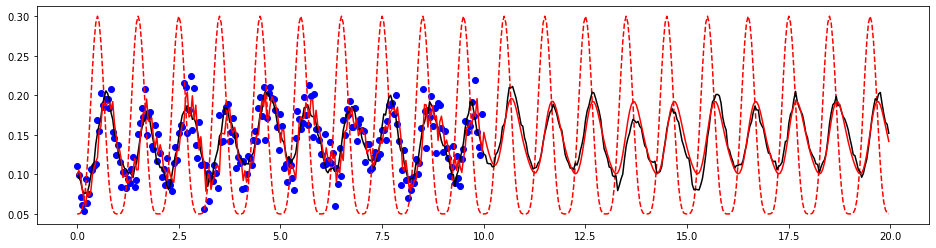

In [6]:
DeltaE = 0.0          # bias
kf_example(DeltaE)

We have recovered the fuel moisture from data with random noise - we **filtered** the noise out. 

Now what if the model is wrong - different from nature? That is always so in reality. Now suppose that the model and the truth are not the same. That is always the case in reality.  Consider a simple case when the model thinks that the equilibrium $E$ is too high.

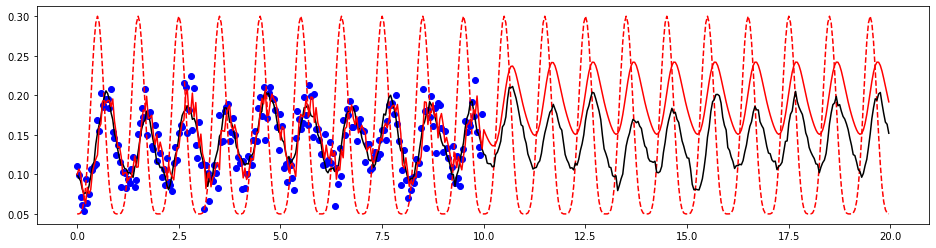

In [7]:
DeltaE = 0.05
kf_example(DeltaE)  

We have found a good estimate of the state $m$, while data is available. Also, the estimated state variance $P$ converges with time - we have *learned* the variance that balances the noise. But for forecasting fuel moisture, we need to continue the fuel moisture model into the future, and we can't have any measurements from future. We only have the equilibrium from weather forecast. And the forecast and the truth disagree.

## Real data

In [8]:
# set up bounds
# Take the first station in the boulding box that has data between time_start and time_s2.
# Then retrieve data for that station between time_start and time_end
time_start = "201806010800"  # June 1 2018 08:00 in format yyyymmddHHMM
time_s2    = "201806010900"  # June 1 2018 09:00 in format yyyymmddHHMM 
time_end   = "201906200900"  # Nov 1 2018 09:00 in format yyyymmddHHMM 
#time_start=  "201810230100"
#time_s2=  "201810230300"
#time_end  =  "201806022300"

We retrieve the fuel moisture data from sensors on weather stations in the Mesowest network. 

 Get all stations with fuel moisture data in a spatial box within one hour: 

In [9]:
!pip install MesoPy
from MesoPy import Meso
bounding_box = "-115, 38, -110, 40"  # min longtitude, latitude
meso_token="b40cb52cbdef43ef81329b84e8fd874f"       # you should get your own if you do more of this
m = Meso(meso_token)                                     # create a Meso object
meso_obss = m.timeseries(time_start, time_s2, bbox=bounding_box, showemptystations = '0', vars='fuel_moisture')   # ask the object for data

In [10]:
meso_obss

{'UNITS': {'position': 'ft', 'fuel_moisture': 'gm', 'elevation': 'ft'},
 'QC_SUMMARY': {'QC_CHECKS_APPLIED': ['sl_range_check'],
  'TOTAL_OBSERVATIONS_FLAGGED': 0.0,
  'PERCENT_OF_TOTAL_OBSERVATIONS_FLAGGED': 0.0},
 'STATION': [{'STATUS': 'ACTIVE',
   'MNET_ID': '2',
   'PERIOD_OF_RECORD': {'start': '1997-01-01T00:00:00Z',
    'end': '2021-11-08T08:27:00Z'},
   'ELEVATION': '6493',
   'NAME': 'BLACK CEDAR',
   'STID': 'BKCU1',
   'SENSOR_VARIABLES': {'date_time': {'date_time': {}},
    'fuel_moisture': {'fuel_moisture_set_1': {'position': '0.98'}}},
   'ELEV_DEM': '6499.3',
   'LONGITUDE': '-112.238864',
   'STATE': 'UT',
   'OBSERVATIONS': {'date_time': ['2018-06-01T08:27:00Z'],
    'fuel_moisture_set_1': [4.9]},
   'RESTRICTED': False,
   'QC_FLAGGED': False,
   'LATITUDE': '38.979242',
   'TIMEZONE': 'America/Denver',
   'ID': '2328'},
  {'STATUS': 'ACTIVE',
   'MNET_ID': '2',
   'PERIOD_OF_RECORD': {'start': '1998-07-30T00:00:00Z',
    'end': '2021-11-08T08:12:00Z'},
   'ELEVATION'

Print the result:

In [11]:
import json
print(json.dumps(meso_obss, indent=4))


{
    "UNITS": {
        "position": "ft",
        "fuel_moisture": "gm",
        "elevation": "ft"
    },
    "QC_SUMMARY": {
        "QC_CHECKS_APPLIED": [
            "sl_range_check"
        ],
        "TOTAL_OBSERVATIONS_FLAGGED": 0.0,
        "PERCENT_OF_TOTAL_OBSERVATIONS_FLAGGED": 0.0
    },
    "STATION": [
        {
            "STATUS": "ACTIVE",
            "MNET_ID": "2",
            "PERIOD_OF_RECORD": {
                "start": "1997-01-01T00:00:00Z",
                "end": "2021-11-08T08:27:00Z"
            },
            "ELEVATION": "6493",
            "NAME": "BLACK CEDAR",
            "STID": "BKCU1",
            "SENSOR_VARIABLES": {
                "date_time": {
                    "date_time": {}
                },
                "fuel_moisture": {
                    "fuel_moisture_set_1": {
                        "position": "0.98"
                    }
                }
            },
            "ELEV_DEM": "6499.3",
            "LONGITUDE": "-112.238864",

Pick one station and get a time series for the station.

In [12]:
station=meso_obss['STATION'][0]
#print(json.dumps(station, indent=4))
lon,lat = (float(station['LONGITUDE']),float(station['LATITUDE']))
print(station['NAME'],'station',station['STID'],'at',lon,lat)
e = 0.01
bb = '%s, %s, %s, %s' % (lon - e, lat - e, lon + e, lat + e)
print('bounding box',bb)
meso_ts = m.timeseries(time_start, time_end, bbox=bb, showemptystations = '0', vars='fuel_moisture')   # ask the object for data
obs_lon, obs_lat = (lon, lat)   # remember station coordinates for later

BLACK CEDAR station BKCU1 at -112.238864 38.979242
bounding box -112.24886400000001, 38.969242, -112.228864, 38.989242


Text(0.5, 1.0, 'BKCU1 10 h fuel moisture data')

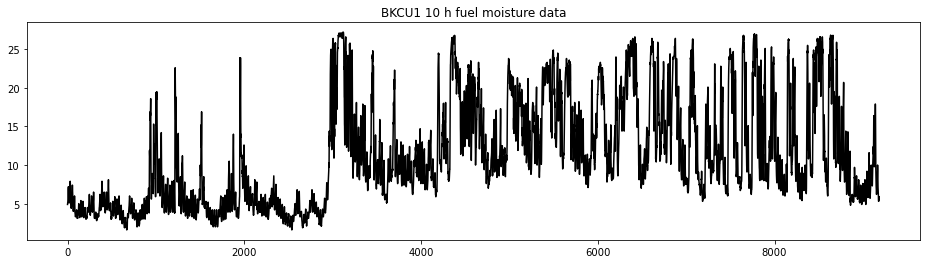

In [13]:
# process the data retrieved for this station
# print(json.dumps(meso_ts['STATION'][0], indent=4))
from datetime import datetime, timedelta, time
import numpy as np
import matplotlib.pyplot as plt
import pytz
station = meso_ts['STATION'][0]
time_str  = station['OBSERVATIONS']['date_time']
obs_time = [datetime.strptime(t, '%Y-%m-%dT%H:%M:%SZ').replace(tzinfo=pytz.UTC) for t in time_str]
start_time = obs_time[0].replace(minute=0)     # remember obs_time and start_time for later
end_time = obs_time[-1]
obs_data = np.array(station['OBSERVATIONS']["fuel_moisture_set_1"])
# display the data retrieved
#for o_time,o_data in zip (obs_time,obs_data):
#    print(o_time,o_data)
%matplotlib inline
plt.figure(figsize=(16,4))
plt.plot(obs_data,linestyle='-',c='k',label='10-h fuel data')
plt.title(station['STID'] + ' 10 h fuel moisture data')


Next, we retrieve weather data for the duration of the station data, from our RTMA stash.

Create a function to transfer RTMA files in GRIB2 format from the stash. The function returns zero if the file transfer succeeded. If the file is not available, it returns a nonzero value. Note: if needed, maybe in future add more sophisticated checks, check the return code of wget and if the file size is correct.

In [14]:
import subprocess,os
def load_rtma(path,file,reload=0):
  url='http://math.ucdenver.edu/~jmandel/rtma/' + path 
  if os.path.exists(file):
    if reload:
      print(file + ' already exists, removing')
      os.remove(file)
    else:
      print(file + ' already exists, exiting')
      # add checking size here
      return 0
  try:
    ret = subprocess.check_output(['wget','--no-clobber','--output-document='+ file, url,],stderr=subprocess.STDOUT).decode() # execute command from python strings
    if os.path.exists(file):
      print('loaded ' + url + ' as ' + file)
      return 0
    else: 
      print('file transfer completed, but the file is missing? ' + url)  
      return 1
  except:
    print('file transfer failed: ' + url)
    return 2


Next, functions to get the files, open as grib, and interpolate to the station coordinates

In [15]:
def rtma_grib(t,var):
    tpath = '%4i%02i%02i/%02i' % (t.year, t.month, t.day, t.hour)  # remote path on server
    tstr  = '%4i%02i%02i%02i_' % (t.year, t.month, t.day, t.hour)  # time string for local path
    gribfile = os.path.join('data',tstr + var + '.grib')
    remote = tpath + '/' + var + '.grib'
    if load_rtma(remote,gribfile):
        print('cannot load remote file',remote,'as',gribfile)
        return []
    else:
        try:
            gf=GribFile(gribfile)
            v = np.array(gf[1].values())
        except:
            print('cannot read grib file',gribfile)
            return []
        print('loaded ',gribfile,' containing array shape ',v.shape)
        return gf[1]   # grib message


In [16]:
from scipy.interpolate import LinearNDInterpolator, interpn
from scipy.optimize import root
def interp_to_lat_lon_slow(lats,lons,v,lat,lon): 
    # on mesh with coordinates lats and lons interpolate v to given lat lon
    interp=LinearNDInterpolator(list(zip(lats.flatten(),lons.flatten())),v.flatten())
    return interp(lat,lon)
def interp_to_lat_lon(lats,lons,v,lat,lon):
    # on mesh with coordinates lats and lons interpolate v to given lat lon
    points=(np.array(range(lats.shape[0]),float),np.array(range(lats.shape[1]),float))  # uniform mesh
    def res(ij):  # interpolation of lons lats on the uniform mesh, to noninteger coordinates   
       return np.hstack((interpn(points,lats,ij)-lat, interpn(points,lons,ij)-lon))
    # solve for xi,xj such that lats(xi,xj)=lat lons(xi,xj)=lon, then interpolate to (xi, xj) on uniform grid 
    result = root(res,(0,0)) # solve res(ij) = 0
    if not result.success:
        print(result.message)
        exit(1)
    return interpn(points,v,result.x) 


The interpolation function needs to  be tested.

In [17]:
def interp_to_lat_lon_test(lats,lons):
    print('testing interp_to_lat_lon')
    vx, vy = np.meshgrid(range(lats.shape[0]),range(lats.shape[1]),indexing='ij')
    i, j = (1,2)
    lat,lon = ((lats[i,j]+lats[i+1,j+1])/2,(lons[i,j]+lons[i+1,j+1])/2)
    vi = interp_to_lat_lon(lats,lons,vx,lat,lon)
    vj = interp_to_lat_lon(lats,lons,vy,lat,lon)
    print(vi,vj,'should be about',i+0.5,j+0.5)
    test_slow = 0
    if test_slow:
        print('Testing against the standard slow method scipy.interpolate.LinearNDInterpolator. Please wait...')
        vi_slow = interp_to_lat_lon_slow(lats,lons,vx,lat,lon)
        print(vi_slow)
        vj_slow = interp_to_lat_lon_slow(lats,lons,vy,lat,lon)
        print(vj_slow)
        
gf = rtma_grib(start_time,'temp')      #  read the first grib file and use it to test interpolation
lats, lons = gf.latlons()
interp_to_lat_lon_test(lats,lons)


data/2018060108_temp.grib already exists, exiting
loaded  data/2018060108_temp.grib  containing array shape  (1377, 2145)
testing interp_to_lat_lon
[1.50000185] [2.50004253] should be about 1.5 2.5


In [18]:
#%debug


Now we are ready to reading the RTMA files and interpolate to the station coordinates

In [19]:
import pandas as pd, json
def read_interp_rtma(varnames,times,lat,lon):
    # read RTMA from start_time to end_time and interpolate to obs_lat obs_lon
    ntimes = len(times)
    time_str = 'time_str'
    j={time_str:times.strftime('%Y-%m-%d %H:%M').tolist()}
    for varname in varnames:
        j[varname]=np.full(ntimes,np.nan)  # initialize array of nans as list
    n=0
    for t in times:
        tim=t.strftime('%Y-%m-%d %H:%M')
        should_be = j[time_str][n]
        if tim != should_be:
            print('n=',n,'time',tim,'expected',should_be)
            raise 'Invalid time' 
        for varname in varnames:
            gf = rtma_grib(t,varname)   # read and create grib object, download if needed
            if gf:
                lats,lons = gf.latlons()    # coordinates
                v = gf.values()
                vi=interp_to_lat_lon(lats,lons,v,lat,lon) # append to array
                print(varname,'at',t,'interpolated to',lat,lon,' value ',vi)
                j[varname][n] = vi
            else:
                print(varname,'at',t,' could not be loaded')
        n = n+1
    return j

In [20]:
import json
jfile = 'rtma.json'
try:
    j = json.load(open(jfile,'r'))
    print('loaded from ',jfile)
    if j['obs_lat']!=obs_lat or j['obs_lon']!=obs_lon:
        raise 'Wrong lon lat'
except:
    print("can't read",jfile,', creating')
    times = pd.date_range(start=time_start,end=time_end,freq='1H')
    varnames=['temp','td','precipa']
    j =    read_interp_rtma(varnames,times,obs_lat,obs_lon)      # temperature
    for varname in varnames:
        j[varname]=j[varname].tolist() 
    j['obs_lat']=obs_lat
    j['obs_lon']=obs_lon
    json.dump(j,open('rtma.json','w'),indent=4)
    print('done')

loaded from  rtma.json


In [21]:
print(json.dumps(j,indent=4))


{
    "time_str": [
        "2018-06-01 08:00",
        "2018-06-01 09:00",
        "2018-06-01 10:00",
        "2018-06-01 11:00",
        "2018-06-01 12:00",
        "2018-06-01 13:00",
        "2018-06-01 14:00",
        "2018-06-01 15:00",
        "2018-06-01 16:00",
        "2018-06-01 17:00",
        "2018-06-01 18:00",
        "2018-06-01 19:00",
        "2018-06-01 20:00",
        "2018-06-01 21:00",
        "2018-06-01 22:00",
        "2018-06-01 23:00",
        "2018-06-02 00:00",
        "2018-06-02 01:00",
        "2018-06-02 02:00",
        "2018-06-02 03:00",
        "2018-06-02 04:00",
        "2018-06-02 05:00",
        "2018-06-02 06:00",
        "2018-06-02 07:00",
        "2018-06-02 08:00",
        "2018-06-02 09:00",
        "2018-06-02 10:00",
        "2018-06-02 11:00",
        "2018-06-02 12:00",
        "2018-06-02 13:00",
        "2018-06-02 14:00",
        "2018-06-02 15:00",
        "2018-06-02 16:00",
        "2018-06-02 17:00",
        "2018-06-02 18:00",


In [22]:
%debug


ERROR:root:No traceback has been produced, nothing to debug.


In [40]:
import json
rtma = json.load(open('rtma.json','r'))
td = np.array(rtma['td'])
t2 = np.array(rtma['temp'])
prec=np.array(rtma['precipa'])
# compute relative humidity
rh = 100*np.exp(17.625*243.04*(td - t2) / (243.04 + t2 - 273.15) / (243.0 + td - 273.15))
Ed = 0.924*rh**0.679 + 0.000499*np.exp(0.1*rh) + 0.18*(21.1 + 273.15 - t2)*(1 - np.exp(-0.115*rh))
Ew = 0.618*rh**0.753 + 0.000454*np.exp(0.1*rh) + 0.18*(21.1 + 273.15 - t2)*(1 - np.exp(-0.115*rh))

Text(0.5, 1.0, 'BKCU1 Temperature (K)')

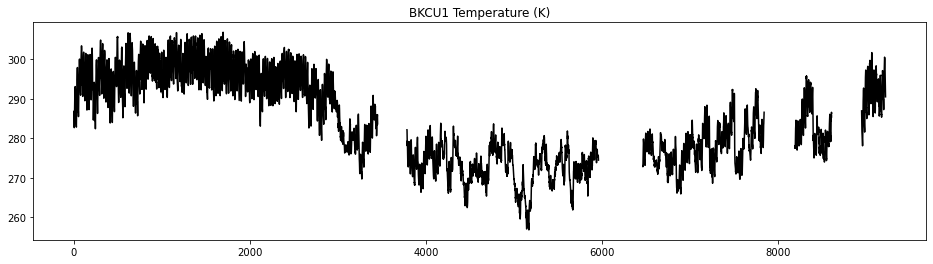

In [34]:
%matplotlib inline
plt.figure(figsize=(16,4))
plt.plot(t2,linestyle='-',c='k',label='Temperature')
plt.title(station['STID'] + ' Temperature (K)')

Text(0.5, 1.0, 'BKCU1 Dew point (K)')

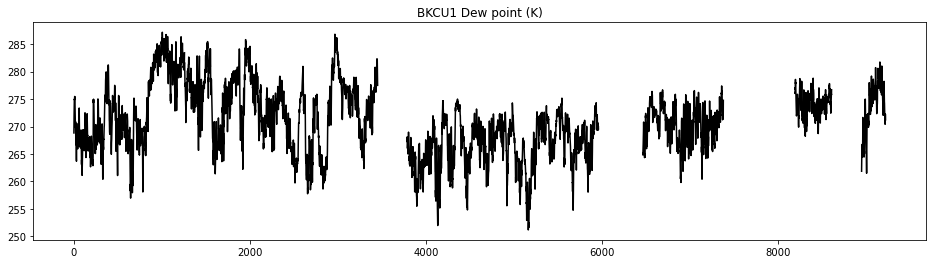

In [35]:
%matplotlib inline
plt.figure(figsize=(16,4))
plt.plot(td,linestyle='-',c='k',label='Dew point')
plt.title(station['STID'] + ' Dew point (K)')

Text(0.5, 1.0, 'BKCU1 relative humidity (%)')

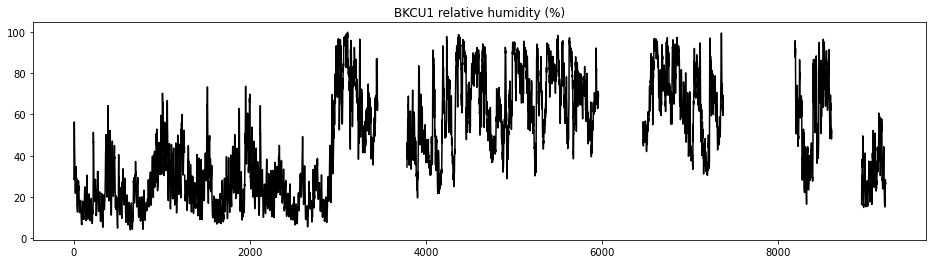

In [36]:
%matplotlib inline
plt.figure(figsize=(16,4))
plt.plot(rh,linestyle='-',c='k',label='Dew point')
plt.title(station['STID'] + ' relative humidity (%)')

Text(0.5, 1.0, 'BKCU1 drying and wetting equilibria (%)')

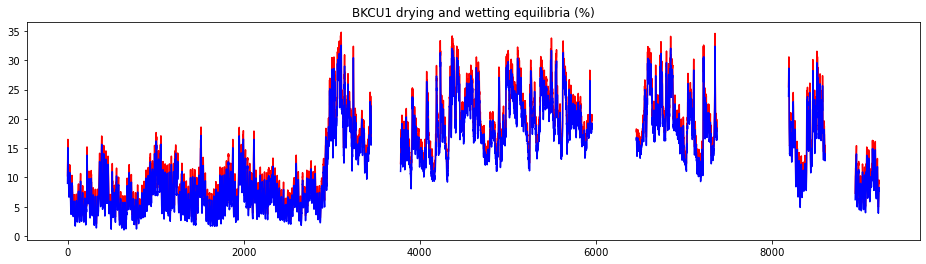

In [41]:
%matplotlib inline
plt.figure(figsize=(16,4))
plt.plot(Ed,linestyle='-',c='r',label='drying equilibrium')
plt.plot(Ew,linestyle='-',c='b',label='wetting equilibrium')
plt.title(station['STID'] + ' drying and wetting equilibria (%)')

Text(0.5, 1.0, 'BKCU1 Precipitation')

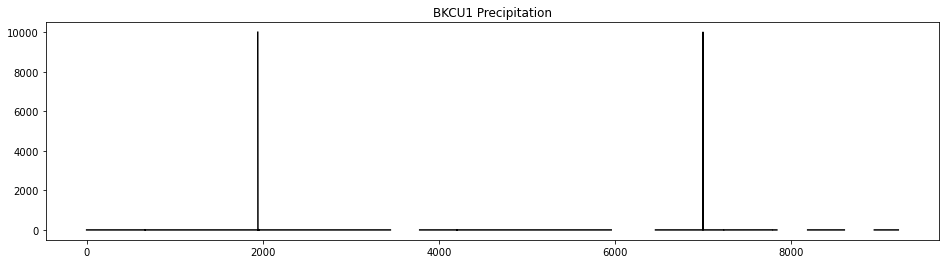

In [26]:
%matplotlib inline
plt.figure(figsize=(16,4))
plt.plot(rtma['precipa'],linestyle='-',c='k',label='Precipitation')
plt.title(station['STID'] + ' Precipitation' )

One special grib file with the terrain height is stored at the root of the stash. This file is a part of the RTMA dataset but no need to download and store every hour, the data should never change. Trying to read it and doing a sanity check. Also,checking if the grid coordinages in this file are the same as before.


In [27]:
hf='ds.terrainh.bin'   # terrain height, same in rtma at all times
load_rtma(hf,hf)
gf = GribFile(hf)[1] 
hgt = np.array(gf.values()) # height in m
print('min height %s max %s' % (np.amin(hgt),np.amax(hgt)))
print('shape',hgt.shape)
hlats, hlons = gf.latlons()     # grid of geo coodinates (computed), should be the same for all rtma files here
hlats = np.array(hlats)         # tuple to numpy array
hlons = np.array(hlons) 
print('difference in lats %s lons %s' % (np.amax(np.absolute(lats-hlats)), np.amax(np.absolute(lons-hlons))))


ds.terrainh.bin already exists, exiting
min height -76.60000000000001 max 4156.900000000001
shape (1377, 2145)
difference in lats 0.0 lons 0.0


## Model with augmented state
In reality, the equilibrium moisture $E$ computed from atmospheric conditions
generally does not agree with the data. We want to add a correction $\Delta
E$ to $E$ constant in time, and identify the new parameter $\Delta E$ from data. 
Because the Kalman filter identifies state, add the parameter to the state.
Define augmented state $u=\left[
\begin{array}
[c]{c}
m\\
\Delta E
\end{array}
\right]  .$ Since $\Delta E$ is constant in time, it satisfies the
differential equation $\frac{d\Delta E}{dt}=0.$ So, we want to estimate the
state $u$ governed by the
$$
\frac{d}{dt}\left[
\begin{array}
[c]{c}
m\\
\Delta E
\end{array}
\right]  =\left[
\begin{array}
[c]{c}
\frac{E+\Delta E-m(t)}{T}\\
0
\end{array}
\right]  ,
$$
which we write as $\frac{du}{dt}=F(u),$ where
$$
F(u)=\left[
\begin{array}
[c]{c}
F_{1}\left(  u\right)  \\
F_{2}\left(  u\right)
\end{array}
\right]  =F\left(  \left[
\begin{array}
[c]{c}
m\\
\Delta E
\end{array}
\right]  \right)  =\left[
\begin{array}
[c]{c}
\left(  E+\Delta E-m(t)\right)  T_{1}\\
0
\end{array}
\right]  ,\quad T_{1}=\frac{1}{T}.
$$
The Jacobian of $F$ is
$$
\left[
\begin{array}
[c]{cc}
\frac{\partial F_{1}}{\partial u_{1}} & \frac{\partial F_{1}}{\partial u_{2}
}\\
\frac{\partial F_{2}}{\partial u_{1}} & \frac{\partial F_{2}}{\partial u_{2}}
\end{array}
\right]  =\left[
\begin{array}
[c]{cc}
\frac{\partial m_{1}}{\partial m_{0}} & \frac{\partial m_{1}}{\partial E}\\
\frac{\partial\Delta E}{\partial m_{0}} & \frac{\partial\Delta E}
{\partial\Delta E}
\end{array}
\right]  =\left[
\begin{array}
[c]{cc}
\frac{\partial m_{1}}{\partial m_{0}} & \frac{\partial m_{1}}{\partial E}\\
0 & 1
\end{array}
\right]
$$
Here is a function that implements the augmented model $F$. The input is
$u_{0}$. The output is $u_{1}$ and the Jacobian $du_{1}/du_{0}$.

In [28]:
def model_augmented(u0,E,T1,tlen=1):
  # state u is the vector [m,dE] with dE correction to equilibrium
  m0 = u0[0]  # decompose u0
  dE = u0[1]
  m1, dm1_dm0, dm1_dE, dm1_dT1  = model_decay(m0,E + dE,T1,tlen=tlen)
  u1 = np.array([m1,dE])
  J = np.array([dm1_dm0, dm1_dE],
               [0.     ,     1.])
  return m0, J

In [29]:
u = np.zeros((2,2*hours)
u[:,0]=[0.1,0.1]             # background state  
P = np.zeros(2,2,2*hours)
P[:,:,0] = np.array([[0.03, 0.],
                  [0.,    0.03]]) # background state covariance
Q = np.array([[0.03, 0.],
            [0,    0.03]]) # process noise covariance
H = np.array([[1., 0.],
             [0.,  .0]])   # first component observed
R = np.array([0.02]) # data variance

DeltaE = 0.05          # bias
for t in range(hours):
  # use lambda construction to pass additional arguments to the model 
  u[:,t+1],P[:,:,t+1] = ext_kf(m[:,t],d2(P[:,:,t]),lambda u: model_decay(u,E[t]+DeltaE,partials=1),Q,
                    d=data[t],H=H,R=R)
for t in range(hours,2*hours - 1):
  u[:,t+1],P[:,:,t+1] = ext_kf(m[t],d2(P[t]),lambda u: model_decay(u,E[t]+DeltaE,partials=1))
  
    
%matplotlib inline
import matplotlib.pyplot as plt 
plt.figure(figsize=(16,4))
plt.plot(day,E,linestyle='--',c='r',label='Equilibrium')
plt.plot(day,m_f,linestyle='-',c='k',label='10-h fuel truth')
plt.scatter(day[0:hours],data[0:hours],c='b',label='10-h fuel data')
plt.plot(day,m,linestyle='-',c='r',label='filtered')




SyntaxError: invalid syntax (<ipython-input-29-3f5099298f53>, line 2)

In [ ]:
DeltaE

In [ ]:
d=np.array([])
if d:
  print('yes')

In [ ]:
for d in range(24):
  print(d)

# With real data

In [ ]:
! pip install intergrid
from intergrid.intergrid import Intergrid  # docs https://pypi.org/project/intergrid/
from datetime import date
import pandas as pd
start_date = date(2018,5,19)
end_date = date(2020,6,1)
for d in pd.date_range(start_date,end_date,freq="1h"):
    path = d.strftime("%Y%m%d/%H")
    print(path)

#Experiments

In [ ]:
import numpy as np
a = np.array([1.])
b = np.array([2.])
c  = a @ b
print('a',a)
print('b',b)
print('c=a@b',c)

# Testers

In [ ]:
# a basic ext_kf test
import numpy as np
u = [1,
     2]
P = [[2 , -1],
    [-1 , 2]]
A = [ [1 ,2],
      [3 ,4]]
u = np.array(u)      
Q = np.array([[1,0],[0,1]])
A = np.array(A)
def fun(u):
  return A @ u, A
F = lambda u: fun(u)
H = [[1, 0],
     [0, 1]]
d = [2,
    3]
R = [[2, 0],
    [0, 2]]
H = np.array(H)      
d = np.array(d)
R = np.array(R)
ua,Pa = ext_kf(u,P,F,Q)
print('ua=',ua)
print('Pa=',Pa)
ua,Pa = ext_kf(u,P,F,Q,d,H,R)
print('ua=',ua)
print('Pa=',Pa)
